In [1]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

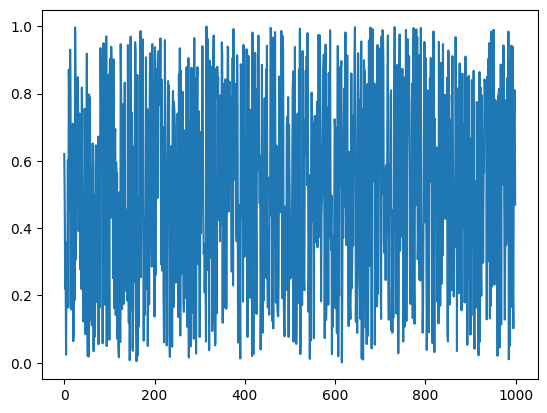

In [4]:
n = 50
p = 10
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25
r= 2
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [3]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100
gamma = 0.1
rho = 1

In [ ]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T #initialising theta as zero vectors
Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0]) #initialising numpy array to store A^t * z and z
for i in range(b):
    if i <= p-1:
        e = np.array([np.zeros(p)])
        e[0][i] = 1
        A = e * 1/sigma2
        if i == 0:
            Alist = A
            AtA = np.array([np.matmul(A.T, A)])
        else:
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
    else:
        X_t = X[i-p].reshape(1, p)
        A = X_t / sigmay
        Alist = np.vstack((Alist, A))
        AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

for t in range(niter):
    print("Start of %sth iteration" % str(t))
    for i in range(b):
        if i <= p-1:
            # e = np.array([np.zeros(p)])
            # e[0][i] = 1
            # A = e * 1/sigma2
            # AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
            # AtA[i] = np.matmul(A.T, A)
            # AtA.append(np.matmul(A.T, A))
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * (np.linalg.norm(np.matmul(Alist[i], theta)))**2/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * np.matmul(Alist[0], theta)
                sigmaz = 1 - sigsig**2
                z = np.append(z, np.random.normal(mu, sigmaz))
                # z.append(np.random.normal(mu, sigmaz))
            else:
                z = np.append(z, 0)
                # z.append(0)
            # print(A)
            Atz[i] = np.reshape(Alist[i] * z[i], (-1,1))
            
        else:
            z = np.append(z, y[i-p] / sigmay)
            Atz[i] = np.reshape(Alist[i] * z[i], (-1,1))
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    # print(theta.shape)
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
    print("-------------------------------------------------------")

In [17]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    for i in range(r): theta[i] = 1
    # print(theta)                                   
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        # print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                # print((np.linalg.norm(np.matmul(Alist[i], theta)))**2)
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        # print(sum(AtA))
        # print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        # print(mu_theta.shape)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(theta.shape)
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])
        # print("End of %sth iteration" % str(t+1))
        # print("-------------------------------------------------------")
    return samples

# trace = splitGibbs(sigma1 = 1, sigma2 = 0.2, sigmay = 1, X = X, y = y, niter = 50000)
trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)
len(trace)

100000

tf.Tensor(
[ 0.84166586  1.0943911  -0.3522608   0.05818282  0.15726537  0.6945126
  0.73906606  0.06063017  0.37449518  0.26040044 -0.40775338 -0.2333603
 -0.63688624  0.47140548  0.0027403  -0.29593706 -0.5526309  -0.07273985
  0.06079626 -0.1267351 ], shape=(20,), dtype=float32)


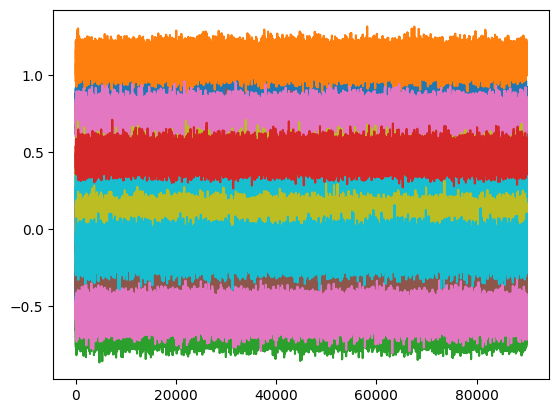

In [18]:
sample = tf.convert_to_tensor(np.asarray(trace[10000:]), dtype=tf.float32)
plt.plot(sample)
ess = tfp.mcmc.effective_sample_size(sample, filter_beyond_positive_pairs=True)
# print(ess.shape)
mean, variance = tf.nn.moments(sample, axes=0)
standard_error = tf.sqrt(variance / ess)

print(mean)

In [21]:
variance

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00195588, 0.00161997, 0.0026655 , 0.00401399, 0.00230449,
       0.0030324 , 0.00328778, 0.00337489, 0.00170583, 0.00277306],
      dtype=float32)>

### Sampling from different initial values, with an initial distribution of theta sampled from a multivariate Gaussian with large variance

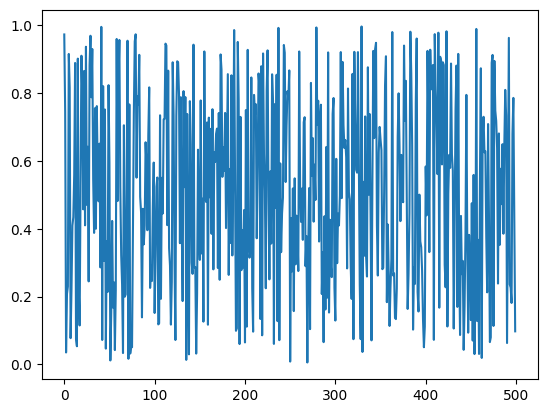

In [19]:
n = 50
p = 10
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25
r= 2
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 100) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [ ]:
trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 10000)

sample = tf.convert_to_tensor(np.asarray(trace[10000:]), dtype=tf.float32)
plt.plot(sample)

ess = tfp.mcmc.effective_sample_size(sample, filter_beyond_positive_pairs=True)
mean, variance = tf.nn.moments(sample, axes=0)
standard_error = tf.sqrt(variance / ess)
print(mean)